In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

import torch
import torch.optim as optim


import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors as SklearnNN
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
import random

from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data

import copy
import time
import statistics
import os

In [2]:
node_features = np.load("../../pre_process/embeddings.npy")
df_sampled = pd.read_pickle("../../pre_process/df_sampled.pkl")

node_features = torch.tensor(node_features, dtype=torch.float32).clone().detach()
print("Amostras no df_sampled:", df_sampled.shape[0])
print("Amostras nos embeddings:", node_features.shape[0])

Amostras no df_sampled: 20757
Amostras nos embeddings: 20757


In [3]:
import pandas as pd

# Carregar o dataset processado
df_sampled = pd.read_pickle("../../pre_process/df_sampled.pkl")

# Contar número de projetos únicos
n_projects = df_sampled["Project_ID"].nunique()
projects = df_sampled["Project_ID"].unique()

print("Número de projetos únicos:", n_projects)
print("IDs dos projetos:", projects)

Número de projetos únicos: 28
IDs dos projetos: [ 3  4  5  7  8  9 10 11 16 17 18 14 22 25 27 26 23 24 29 30 31 43 34 35
 36 13 12 33]


In [8]:
BERT_MODEL_NAME = "all-MiniLM-L6-v2"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PROJECTS = [13,34,36]  # Projetos de treino: "*" para todos exceto o de teste, ou lista explícita [12, 14]
PROJECTS = ["*"] # proejtos de treino
PROJECT_NAMES = { # projetos de teste
    36: "MULE",
    43: "EVG",
    12: "TIMOB",
    4:  "MESOS"
}
PROJECT_ID = 4  # Projeto de teste MULE(36), EVG(43), TIMOB(12), MESOS(4)
project_name = PROJECT_NAMES.get(PROJECT_ID, f"project_{PROJECT_ID}")
VERSAO_MODELO = f"gnc_cross_{project_name}"

# Carregar dados
node_features_all = np.load("../../pre_process/embeddings.npy")
df_sampled = pd.read_pickle("../../pre_process/df_sampled.pkl")

# Interpretar PROJECTS
if "*" in PROJECTS:
    all_projects = df_sampled["Project_ID"].unique()
    train_projects = [pid for pid in all_projects if pid != PROJECT_ID]
else:
    train_projects = PROJECTS

# Separar conjuntos de treino e teste
df_train = df_sampled[df_sampled["Project_ID"].isin(train_projects)]
df_test = df_sampled[df_sampled["Project_ID"] == PROJECT_ID]

# Concatenar para manter índice consistente
df_all = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
node_features = np.vstack(df_all["BERT_Embedding"])
node_features = torch.tensor(node_features, dtype=torch.float32).clone().detach()


# Criar arestas kNN
k = 4
sknn = SklearnNN(n_neighbors=k, metric="cosine").fit(node_features)
_, indices = sknn.kneighbors(node_features)

edges = []
for i in range(len(df_all)):
    for j in range(1, k):  # Ignora auto-loop
        edges.append([i, indices[i, j]])

edge_index = torch.tensor(edges, dtype=torch.long).T

# Tornar bidirecional
edge_index_bi = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Remover duplicatas
sorted_edge_index = torch.stack([
    torch.min(edge_index_bi[0], edge_index_bi[1]),
    torch.max(edge_index_bi[0], edge_index_bi[1])
], dim=0)

edge_index_unique = torch.unique(sorted_edge_index, dim=1)

# Criar o objeto PyG
data = Data(
    x=node_features,
    edge_index=edge_index_unique
)

print("Grafo intra-projeto criado (bidirecional):")
print("  - Nós:", data.x.shape)
print("  - Arestas:", data.edge_index.shape)


# Função para filtrar subgrafos isolados
def filter_edges_by_split(edge_index, train_idx, val_idx, test_idx):
    allowed_train_val = set(train_idx.tolist() + val_idx.tolist())
    allowed_test = set(test_idx.tolist())

    filtered_edges = []

    for src, dst in edge_index.T.tolist():
        if (src in allowed_train_val and dst in allowed_train_val) or \
           (src in allowed_test and dst in allowed_test):
            filtered_edges.append([src, dst])

    return torch.tensor(filtered_edges, dtype=torch.long).T


Grafo intra-projeto criado (bidirecional):
  - Nós: torch.Size([20757, 384])
  - Arestas: torch.Size([2, 47915])


In [9]:
# CONFIGURAÇÃO DE RUNS 
N_RUNS = 10
OUT_DIR = f"runs_results_{project_name}"
os.makedirs(OUT_DIR, exist_ok=True)

# Hiperparâmetros 
BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 1e-4
DROPOUT = 0
PATIENCE = 5
NORMALIZE_TYPE = "minmax"  # "minmax", "standard", or None
SEED = 42

# Backup do edge_index original
edge_index_orig = data.edge_index.cpu().clone().detach()

class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x).view(-1)


def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def prepare_split_and_loaders_cross(seed, edge_index_backup):
    """
    Para o cenário cross-project: restaura grafo, cria split treino/val apenas entre os nós de treino,
    ajusta scaler no train, define data.y e cria NeighborLoader para train/val/test.
    Retorna: scaler_local, train_loader, val_loader, test_loader, train_idx_run, val_idx_run, test_idx (fixo)
    """
    # Restaura grafo global original
    data.edge_index = edge_index_backup.clone().to(data.x.device)

    # train_idx_base contém todos os nós de treino (todos os projetos de treino)
    train_idx_base = df_all[df_all["Project_ID"].isin(train_projects)].index.to_numpy()
    test_idx = df_all[df_all["Project_ID"] == PROJECT_ID].index.to_numpy()

    # Split interno do train -> train/val (usando apenas train_idx_base)
    train_idx_run, val_idx_run = train_test_split(train_idx_base, test_size=0.15, random_state=seed)

    # Ajustar scaler APENAS com dados de treino (evita leakage)
    sp_train = df_all.loc[train_idx_run, "Story_Point"].fillna(0).values.reshape(-1, 1)
    if NORMALIZE_TYPE == "minmax":
        scaler_local = MinMaxScaler().fit(sp_train)
    elif NORMALIZE_TYPE == "standard":
        scaler_local = StandardScaler().fit(sp_train)
    else:
        scaler_local = None

    # Transformar todos os rótulos (train+val+test) com scaler ajustado no train
    sp_all = df_all["Story_Point"].fillna(0).values.reshape(-1, 1)
    if scaler_local is not None:
        sp_all_scaled = scaler_local.transform(sp_all).ravel()
    else:
        sp_all_scaled = sp_all.ravel()

    data.y = torch.tensor(sp_all_scaled, dtype=torch.float32)

    # Filtrar arestas entre grupos diferentes (train/val vs test)
    data.edge_index = filter_edges_by_split(
        edge_index=data.edge_index,
        train_idx=train_idx_run,
        val_idx=val_idx_run,
        test_idx=test_idx
    ).to(data.x.device)

    # Checagem 
    src, dst = data.edge_index.cpu().numpy()
    train_val_set = set(train_idx_run.tolist() + val_idx_run.tolist())
    test_set = set(test_idx.tolist())
    cross_edges = [(s,d) for s,d in zip(src,dst) if (s in train_val_set and d in test_set) or (d in train_val_set and s in test_set)]
    if len(cross_edges) > 0:
        print(f"ERRO: Existem {len(cross_edges)} arestas entre treino/val e teste! (seed {seed})")

    # Criar loaders
    train_loader = NeighborLoader(
        data,
        num_neighbors=[3,3],
        batch_size=BATCH_SIZE,
        input_nodes=torch.tensor(train_idx_run),
        shuffle=True
    )
    val_loader = NeighborLoader(
        data,
        num_neighbors=[3,3],
        batch_size=BATCH_SIZE,
        input_nodes=torch.tensor(val_idx_run),
        shuffle=False
    )
    test_loader = NeighborLoader(
        data,
        num_neighbors=[3,3],
        batch_size=BATCH_SIZE,
        input_nodes=torch.tensor(test_idx),
        shuffle=False
    )

    return scaler_local, train_loader, val_loader, test_loader, train_idx_run, val_idx_run, test_idx


def evaluate_model(model, dataloader, criterion):
    model.eval()
    predictions = []
    actuals = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(DEVICE)
            outputs = model(batch).cpu().numpy()
            targets = batch.y.cpu().numpy()
            loss = criterion(torch.tensor(outputs), torch.tensor(targets))
            total_loss += loss.item()
            predictions.extend(outputs)
            actuals.extend(targets)

    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    errors = np.abs(np.array(predictions) - np.array(actuals))
    with np.errstate(divide='ignore', invalid='ignore'):
        within_50 = np.where(np.array(actuals) != 0, errors <= (0.50 * np.array(actuals)), errors == 0)
    pred_50 = float(np.mean(within_50))

    return total_loss / max(1, len(dataloader)), float(mae), float(mse), float(mdae), float(pred_50)

# Loop de N runs (cross-project) 
all_run_results = []
print(f"Iniciando {N_RUNS} runs (cross-project) - test project: {project_name} (ID {PROJECT_ID})")

for run_id in range(N_RUNS):
    run_seed = SEED + run_id
    set_all_seeds(run_seed)

    # preparar split/loaders (restaurando edge_index original)
    scaler_run, train_loader, val_loader, test_loader, train_idx_run, val_idx_run, test_idx_run = prepare_split_and_loaders_cross(run_seed, edge_index_orig)

    # Instanciar modelo, optimizer, scheduler
    in_channels = data.x.size(1)
    hidden_dim = 64
    model = GCNModel(in_channels, hidden_dim).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=(PATIENCE//2)+1, factor=0.5)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_model_state = None
    train_losses = []
    val_mse_history = []

    start_time = time.time()
    print(f"\n--- Run {run_id+1}/{N_RUNS} (seed={run_seed}) ---")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch)
            targets = batch.y.to(DEVICE)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / max(1, len(train_loader))
        train_losses.append(avg_train_loss)

        _, _, val_mse, *_ = evaluate_model(model, val_loader, criterion)
        val_mse_history.append(val_mse)

        print(f"\rRun {run_id+1}/{N_RUNS} Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f} - Val MSE: {val_mse:.6f}", end="", flush=True)

        # early stopping
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        scheduler.step(val_mse)

        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping (run {run_id+1}) after epoch {epoch+1}. Best Val MSE: {best_val_loss:.6f}")
            break

    # restaura melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    elapsed = time.time() - start_time

    # avaliação final no teste
    _, mae_scaled, mse_scaled, mdae_scaled, pred50_scaled = evaluate_model(model, test_loader, criterion)

    # converter métricas para escala real 
    if scaler_run is not None:
        if NORMALIZE_TYPE == "minmax":
            SP_MIN, SP_MAX = df_test["Story_Point"].min(), df_test["Story_Point"].max()
            scale_factor = SP_MAX - SP_MIN
            if scale_factor == 0:
                scale_factor = 1.0
            test_metrics_real = {
                "MAE": mae_scaled * scale_factor,
                "MSE": mse_scaled * (scale_factor ** 2),
                "MdAE": mdae_scaled * scale_factor,
                "Pred(50)": pred50_scaled
            }
        elif NORMALIZE_TYPE == "standard":
            std_dev_real = df_test["Story_Point"].std()
            if std_dev_real == 0:
                std_dev_real = 1.0
            test_metrics_real = {
                "MAE": mae_scaled * std_dev_real,
                "MSE": mse_scaled * (std_dev_real ** 2),
                "MdAE": mdae_scaled * std_dev_real,
                "Pred(50)": pred50_scaled
            }
        else:
            test_metrics_real = {"MAE": mae_scaled, "MSE": mse_scaled, "MdAE": mdae_scaled, "Pred(50)": pred50_scaled}
    else:
        test_metrics_real = {"MAE": mae_scaled, "MSE": mse_scaled, "MdAE": mdae_scaled, "Pred(50)": pred50_scaled}

    # salvar resultados da run
    run_result = {
        "run_id": run_id + 1,
        "seed": run_seed,
        "elapsed_sec": elapsed,
        "best_val_mse": float(best_val_loss),
        "epochs_trained": epoch+1,
        "train_loss_history": train_losses,
        "val_mse_history": val_mse_history,
        "test_metrics_scaled": {"MAE": float(mae_scaled), "MSE": float(mse_scaled), "MdAE": float(mdae_scaled), "Pred(50)": float(pred50_scaled)},
        "test_metrics_real": {k: float(v) for k, v in test_metrics_real.items()}
    }

    # salvar arquivos
    json_path = os.path.join(OUT_DIR, f"{VERSAO_MODELO}_run{run_id+1}_seed{run_seed}.json")
    torch_path = os.path.join(OUT_DIR, f"{VERSAO_MODELO}_run{run_id+1}_seed{run_seed}.pt")
    with open(json_path, "w") as f:
        json.dump(run_result, f, indent=4)
    torch.save(best_model_state, torch_path)

    all_run_results.append(run_result)
    try:
        torch.cuda.empty_cache()
    except:
        pass

# --- Consolidação final ---
maes = [r["test_metrics_real"]["MAE"] for r in all_run_results]
mses = [r["test_metrics_real"]["MSE"] for r in all_run_results]
mdaes = [r["test_metrics_real"]["MdAE"] for r in all_run_results]
pred50s = [r["test_metrics_real"]["Pred(50)"] for r in all_run_results]

summary = {
    "n_runs": N_RUNS,
    "seed_base": SEED,
    "MAE_mean": float(statistics.mean(maes)),
    "MAE_std": float(statistics.pstdev(maes)),
    "MSE_mean": float(statistics.mean(mses)),
    "MSE_std": float(statistics.pstdev(mses)),
    "MdAE_mean": float(statistics.mean(mdaes)),
    "MdAE_std": float(statistics.pstdev(mdaes)),
    "Pred50_mean": float(statistics.mean(pred50s)),
    "Pred50_std": float(statistics.pstdev(pred50s)),
    "per_run_files": [os.path.basename(f"{VERSAO_MODELO}_run{r['run_id']}_seed{r['seed']}.json") for r in all_run_results]
}

summary_path = os.path.join(OUT_DIR, f"{VERSAO_MODELO}_summary_{N_RUNS}runs.json")
with open(summary_path, "w") as f:
    json.dump({"summary": summary, "runs": all_run_results}, f, indent=4)

print("\nAll cross-project runs finished.")
print("Summary saved to:", summary_path)
print("MAE mean (real scale):", summary["MAE_mean"], "±", summary["MAE_std"])


Iniciando 10 runs (cross-project) - test project: MESOS (ID 4)

--- Run 1/10 (seed=42) ---


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Run 1/10 Epoch 28/200 - Train Loss: 0.000550 - Val MSE: 0.000689
Early stopping (run 1) after epoch 28. Best Val MSE: 0.000660


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 2/10 (seed=43) ---
Run 2/10 Epoch 17/200 - Train Loss: 0.000660 - Val MSE: 0.000749
Early stopping (run 2) after epoch 17. Best Val MSE: 0.000728


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 3/10 (seed=44) ---
Run 3/10 Epoch 38/200 - Train Loss: 0.000509 - Val MSE: 0.000612
Early stopping (run 3) after epoch 38. Best Val MSE: 0.000587


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 4/10 (seed=45) ---
Run 4/10 Epoch 31/200 - Train Loss: 0.000508 - Val MSE: 0.000685
Early stopping (run 4) after epoch 31. Best Val MSE: 0.000682


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 5/10 (seed=46) ---
Run 5/10 Epoch 29/200 - Train Loss: 0.000522 - Val MSE: 0.000836
Early stopping (run 5) after epoch 29. Best Val MSE: 0.000790


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 6/10 (seed=47) ---
Run 6/10 Epoch 65/200 - Train Loss: 0.000381 - Val MSE: 0.000556
Early stopping (run 6) after epoch 65. Best Val MSE: 0.000549


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 7/10 (seed=48) ---
Run 7/10 Epoch 61/200 - Train Loss: 0.000345 - Val MSE: 0.000509
Early stopping (run 7) after epoch 61. Best Val MSE: 0.000495


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 8/10 (seed=49) ---
Run 8/10 Epoch 45/200 - Train Loss: 0.000424 - Val MSE: 0.000744
Early stopping (run 8) after epoch 45. Best Val MSE: 0.000736


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 9/10 (seed=50) ---
Run 9/10 Epoch 37/200 - Train Loss: 0.000507 - Val MSE: 0.000644
Early stopping (run 9) after epoch 37. Best Val MSE: 0.000615


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



--- Run 10/10 (seed=51) ---
Run 10/10 Epoch 44/200 - Train Loss: 0.000423 - Val MSE: 0.000504
Early stopping (run 10) after epoch 44. Best Val MSE: 0.000503

All cross-project runs finished.
Summary saved to: runs_results_MESOS/gnc_cross_MESOS_summary_10runs.json
MAE mean (real scale): 0.2584615782373031 ± 0.02202675891559618


In [12]:
# Configurações do modelo
BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 1e-4
DROPOUT = 0
PATIENCE = 5  # Número máximo de épocas sem melhora antes de parar
NORMALIZE_TYPE = "minmax"  # Opções: "minmax", "standard", None
SEED = 42

    
# Normalização 

# Story Points do conjunto de treino (base para ajuste do scaler)
story_points_train = df_train["Story_Point"].fillna(0).values.reshape(-1, 1)

# Ajustar o scaler apenas com os dados de treino
if NORMALIZE_TYPE == "minmax":
    scaler = MinMaxScaler().fit(story_points_train)
elif NORMALIZE_TYPE == "standard":
    scaler = StandardScaler().fit(story_points_train)
else:
    scaler = None

# Aplicar transformação em todo o grafo (df_all)
story_points_all = df_all["Story_Point"].fillna(0).values.reshape(-1, 1)

if scaler is not None:
    story_points = scaler.transform(story_points_all).ravel()
else:
    story_points = story_points_all.ravel()

# Definir os targets dos nós
data.y = torch.tensor(story_points, dtype=torch.float32)



# Fixar seed para Python
random.seed(SEED)
# Fixar seed para NumPy
np.random.seed(SEED)
# Fixar seed para PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_idx = df_all[df_all["Project_ID"].isin(train_projects)].index.to_numpy()
test_idx = df_all[df_all["Project_ID"] == PROJECT_ID].index.to_numpy()

# Validação como split interno do treino
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED)


# Isolar subgrafos treino/validacao e teste: removendo arestas entre grupos diferentes
data.edge_index = filter_edges_by_split(
    edge_index=data.edge_index,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)

# Checar se existem arestas cruzadas entre treino/validação e teste
src, dst = data.edge_index.numpy()
train_val_set = set(train_idx.tolist() + val_idx.tolist())
test_set = set(test_idx.tolist())

cross_edges = [
    (s, d) for s, d in zip(src, dst)
    if (s in train_val_set and d in test_set) or (d in train_val_set and s in test_set)
]

if len(cross_edges) > 0:
    print(f"ERRO: Existem {len(cross_edges)} arestas entre treino/validação e teste!")
else:
    print("Sem vazamento de arestas entre treino/validação e teste.")




train_loader = NeighborLoader(
    data,
    num_neighbors=[3,3],
    batch_size=BATCH_SIZE,
    input_nodes=torch.tensor(train_idx),
    shuffle=True
)

val_loader = NeighborLoader(
    data,
    num_neighbors=[3,3],
    batch_size=BATCH_SIZE,
    input_nodes=torch.tensor(val_idx),
    shuffle=False
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[3,3],
    batch_size=BATCH_SIZE,
    input_nodes=torch.tensor(test_idx),
    shuffle=False
)


class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x).view(-1)


in_channels=data.x.size(1)
hidden_dim = 64  # Ajustável
model = GCNModel(in_channels, hidden_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)


# Reduz a learning rate automaticamente se necessário
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=(PATIENCE // 2)+1, factor=0.5
)


criterion = nn.MSELoss()

# Função de treino
def train_model(model, train_loader, val_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)  # Move o subgrafo para a GPU se disponível

        optimizer.zero_grad()
        outputs = model(batch)  
        targets = batch.y.to(DEVICE)
  

        loss = criterion(outputs, targets)  # Calcula erro entre predição e Story_Point
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Avaliação no conjunto de validação
    val_loss = evaluate_model(model, val_loader, criterion)

    return avg_train_loss, val_loss

# Função de avaliação para modelo GNN heterogêneo
def evaluate_model(model, dataloader, criterion):
    model.eval()
    predictions = []
    actuals = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(DEVICE)  #  Move o subgrafo para a GPU se disponível

            outputs = model(batch).cpu().numpy()  # O modelo recebe o subgrafo inteiro
            targets = batch.y.cpu().numpy() # Pega os rótulos  das issues

            loss = criterion(torch.tensor(outputs), torch.tensor(targets))  # Calcula perda
            total_loss += loss.item()

            predictions.extend(outputs)
            actuals.extend(targets)


    # Cálculo das métricas
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    errors = np.abs(np.array(predictions) - np.array(actuals))
    within_50 = errors <= (0.50 * np.array(actuals))
    pred_50 = np.mean(within_50)

    return total_loss / len(dataloader), mae, mse, mdae, pred_50


# Treinamento do modelo com validação
print("Início Treinamento")
train_losses = []
val_losses = []

best_val_loss = float("inf")
epochs_no_improve = 0  # Contador de épocas sem melhora
best_model_state = None  # Salva os melhores pesos

for epoch in range(EPOCHS):
    train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion)

    train_losses.append(train_loss)
   
    _, _, mse, *_ = val_loss  # extrai só o MSE da tupla

    val_losses.append(mse) 

    print(f"\rEpoch {epoch+1}/{EPOCHS} - Train Loss(scaled): {train_loss:.6f} - Val Loss (MSE scaled): {mse:.6f}", 
      end="", flush=True)
    
 # Verifica se a validação melhorou
    if mse < best_val_loss:
        best_val_loss = mse
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Salva o melhor modelo
    else:
        epochs_no_improve += 1
    

    #Atualiza a taxa de aprendizado baseado na validação
    scheduler.step(mse)

    # Early Stopping
    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly Stopping ativado! Melhor Val Loss: {best_val_loss:.6f} na época {epoch+1-PATIENCE}")
        break

# Restaura o melhor modelo salvo
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print("Treinamento concluído!")

# Avaliação final no conjunto de teste
_, *test_metrics = evaluate_model(model, test_loader, criterion)

metric_names = ["MAE", "MSE", "MdAE", "Pred(50)"]

# print("\nMétricas no Conjunto de Teste (Normalizadas):")
# for name, value in zip(metric_names, test_metrics):
#     print(f"{name}: {value:.9f}")

# Salvar configurações do modelo
config = {
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "epochs_stop": epoch+1-PATIENCE,
    "learning_rate": LEARNING_RATE,
    "best_val_loss": best_val_loss,
    "normalization": NORMALIZE_TYPE,  # Armazena o tipo de normalização usada
    "dropout": str(DROPOUT), 
    "bert": BERT_MODEL_NAME,
    "SEED": SEED
}

#  Ajustar métricas para a escala real baseado em NORMALIZE_TYPE
if NORMALIZE_TYPE == "minmax":
    SP_MIN, SP_MAX = df_test["Story_Point"].min(), df_test["Story_Point"].max()
    scale_factor = SP_MAX - SP_MIN
    if scale_factor == 0:
        scale_factor = 1.0  # evitar multiplicação por zero;

    test_metrics_real = {
        "MAE": test_metrics[0] * scale_factor,
        "MSE": test_metrics[1] * (scale_factor ** 2),
        "MdAE": test_metrics[2] * scale_factor,
        "Pred(50)": test_metrics[3] 
    }
elif NORMALIZE_TYPE == "standard":
     # Usando os valores reais da normalização nos cálculos
    std_dev_real = df_test["Story_Point"].std()  # Obtém o desvio padrão real dos dados
    if std_dev_real == 0:
        std_dev_real = 1.0

    test_metrics_real = {
        "MAE": test_metrics[0] * std_dev_real,
        "MSE": test_metrics[1] * (std_dev_real ** 2),
        "MdAE": test_metrics[2] * std_dev_real,
        "Pred(50)": test_metrics[3] 
    }
else:
    # Se não houver normalização, os valores já estão na escala real
    test_metrics_real = {name: float(value) for name, value in zip(metric_names, test_metrics)}

print("\nMétricas no Conjunto de Teste (Escala Real de Story Points):")
for name, value in test_metrics_real.items():
    print(f"{name}: {value:.3f}")

# Atualizar o dicionário config com os valores ajustados
config["test_metrics"] = {name: float(value) for name, value in test_metrics_real.items()}

# Criar nome do arquivo com os valores reais
file_name_real = f"{VERSAO_MODELO}_MAE_{test_metrics_real['MAE']:.3f}_MdAE_{test_metrics_real['MdAE']:.3f}.json"

with open(file_name_real, "w") as f:
    json.dump(config, f, indent=4)

print(f"\nConfigurações do modelo com erros reais salvas em: {file_name_real}")


Sem vazamento de arestas entre treino/validação e teste.
Início Treinamento


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Epoch 86/200 - Train Loss(scaled): 0.000276 - Val Loss (MSE scaled): 0.000409
Early Stopping ativado! Melhor Val Loss: 0.000395 na época 81
Treinamento concluído!

Métricas no Conjunto de Teste (Escala Real de Story Points):
MAE: 0.673
MSE: 0.855
MdAE: 0.492
Pred(50): 0.307

Configurações do modelo com erros reais salvas em: gnc_cross_MULE_MAE_0.673_MdAE_0.492.json


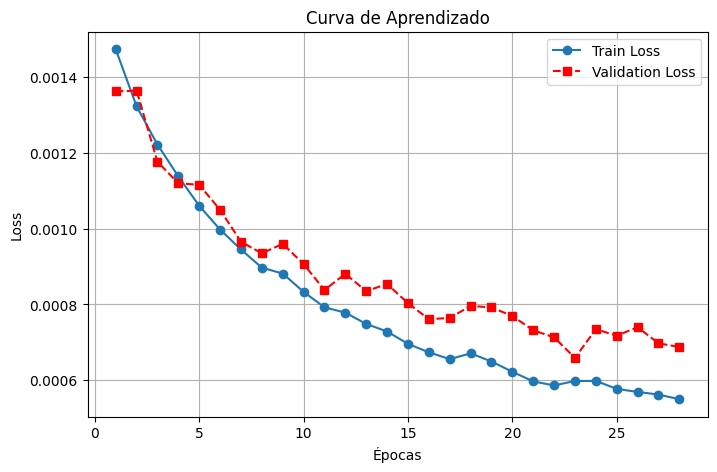

In [19]:
import matplotlib.pyplot as plt
# Plotando a curva de aprendizado
plt.figure(figsize=(8, 5))
# Garantir que todas as épocas sejam plotadas corretamente
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
plt.plot(epochs, val_losses, marker='s', linestyle='--', label='Validation Loss', color='red')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curva de Aprendizado")
plt.legend()
plt.grid()
plt.show()